In [59]:
import os

# Specify the bin folder path of OpenSim installation
# (Use 'r' prefix to avoid backslash errors)
opensim_bin_path = r'C:\OpenSim 4.5\bin'

try:
    os.add_dll_directory(opensim_bin_path)
except AttributeError:
    # For Python versions below 3.8 (for compatibility)
    os.environ['PATH'] = opensim_bin_path + ';' + os.environ['PATH']

import opensim as osim

# Test
print(f"OpenSim Version: {osim.__version__}")

OpenSim Version: 4.5


# Rajagopal2016 vs RajagopalLaiUhlrich2023 Model Comparison

## Basic Information

### Rajagopal2016.osim
- **Based on**: Original model from Rajagopal et al. (2016) paper
- **Modifications**:
  - Updated to OpenSim 4.5 XML format
  - Set `fiber_damping` to 0.1 for all muscles (Millard et al. 2013 recommendation)

### RajagopalLaiUhlrich2023.osim
- **Based on**: Rajagopal2016 model with additional modifications
- **Modifications**:
  1. **Lai et al. (2017) modifications**:
     - Improvements for high hip and knee flexion simulations
     - Increased knee flexion range
     - Updated knee muscle paths
     - Modified force-generating properties of 11 muscles
  
  2. **Uhlrich et al. (2022) modifications**:
     - Calibrated passive muscle force curves to match experimental data from Silder et al. (2007)
     - Updated hip abductor muscle paths to more closely align with MRI and experimental data

## Key Differences Summary

| Item | Rajagopal2016 | RajagopalLaiUhlrich2023 |
|------|---------------|-------------------------|
| **Number of muscles** | 160 | 160 |
| **Muscle type** | Millard2012EquilibriumMuscle | Millard2012EquilibriumMuscle |
| **High flexion support** | Limited | Improved (Lai et al.) |
| **Passive force curve** | Default | Experimental data-based calibration (Uhlrich et al.) |
| **Hip abductor path** | Default | MRI/experimental data-based (Uhlrich et al.) |
| **11 muscle properties** | Default | Modified (Lai et al.) |

## When to Use

### Recommended for Rajagopal2016:
- General gait simulations
- When you want to use the original model characteristics as-is
- Standard analysis tasks

### Recommended for RajagopalLaiUhlrich2023:
- Simulations involving high hip/knee flexion (e.g., stair climbing, deep squatting)
- When more accurate passive muscle force is needed
- When a model reflecting latest research results is needed
- Knee contact force analysis (Uhlrich et al. research purpose)

## Accuracy Comparison

### General Answer: **RajagopalLaiUhlrich2023 is more accurate**

**Reasons:**
1. **Experimental data-based calibration**: Passive muscle force curves are calibrated to match experimental data from Silder et al. (2007)
2. **MRI-based muscle paths**: Hip abductor paths are updated to more closely align with MRI and experimental data
3. **High flexion motion validation**: Lai et al. (2017) addressed and validated issues with high flexion motions
4. **Latest research reflection**: More recent model reflecting research results up to 2022

### However, it depends on the purpose:

#### Rajagopal2016 is more suitable when:
- **Original paper reproduction**: When reproducing results from Rajagopal et al. (2016) paper
- **Standard benchmark**: When a standard model is needed for comparison with other studies
- **Simple gait analysis**: Both models are sufficiently accurate for general gait simulations

#### RajagopalLaiUhlrich2023 is more accurate when:
- **High flexion motions** (knee flexion > 90°, hip flexion > 90°)
- **Analysis where passive muscle force is important** (e.g., passive joint moment analysis)
- **Knee contact force analysis**
- **Analysis aligned with latest research standards**

### Conclusion:
In most cases, **RajagopalLaiUhlrich2023** is recommended, especially:
- Higher agreement with experimental data
- More accurate over a wider range of motions
- Reflects latest research results

However, **Rajagopal2016** should be used when reproducing specific paper results or when standard benchmarks are needed.

## References

- **Rajagopal et al. (2016)**: Full-body musculoskeletal model for muscle-driven simulation of human gait
- **Lai et al. (2017)**: Why are antagonist muscles co-activated in my simulation?
- **Uhlrich et al. (2022)**: Muscle coordination retraining inspired by musculoskeletal simulations reduces knee contact force
- **Silder et al. (2007)**: Identification of passive elastic joint moment-angle relationships in the lower extremity


Analyzing muscle: soleus_r
Muscle type: Millard2012EquilibriumMuscle
Curves loaded successfully!


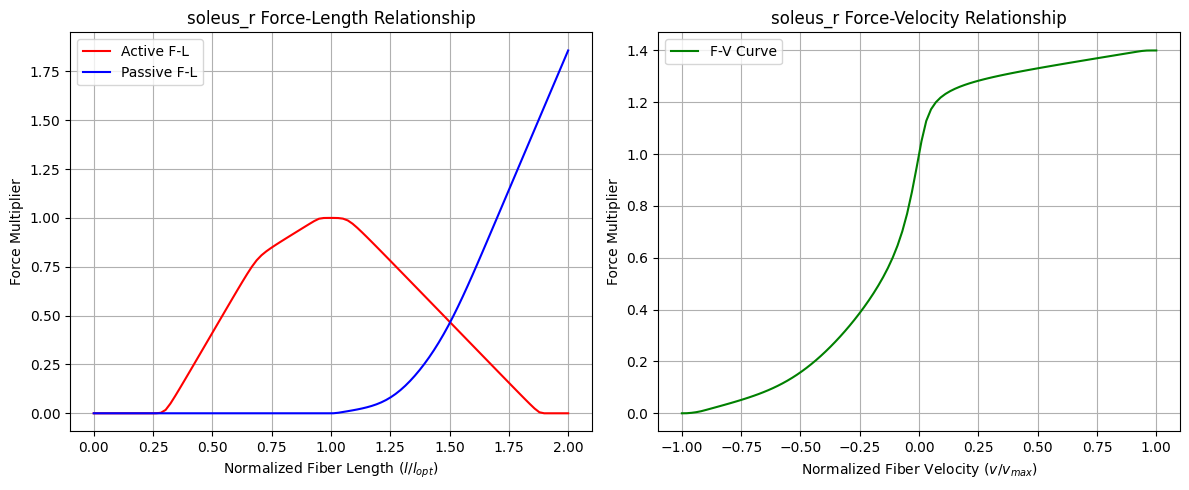

In [60]:
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt

# 1. Load model - Rajagopal2016 model
model_path = 'opensim_models/Rajagopal/Rajagopal2016.osim'
model = osim.Model(model_path)
model.initSystem()

# 2. Select muscle to analyze - In Rajagopal2016, use 'bflh_r' (biceps femoris long head)
# All muscles in Rajagopal2016 model are Millard2012EquilibriumMuscle type.
muscle_name = 'soleus_r'
base_muscle = model.getMuscles().get(muscle_name)
muscle = osim.Millard2012EquilibriumMuscle.safeDownCast(base_muscle)

if not muscle:
    print(f"Error: Muscle '{muscle_name}' not found or is not Millard2012EquilibriumMuscle type.")
    print(f"Muscle type: {base_muscle.getConcreteClassName() if base_muscle else 'Not found'}")
    exit()

print(f"Analyzing muscle: {muscle_name}")
print(f"Muscle type: {muscle.getConcreteClassName()}")

# 3. Get Curve objects
# For Millard2012EquilibriumMuscle, use getFiberForceLengthCurve() for passive (force-length) curve.
active_fl_curve = muscle.getActiveForceLengthCurve()
fiber_fl_curve = muscle.getFiberForceLengthCurve()
fv_curve = muscle.getForceVelocityCurve()

print("Curves loaded successfully!")

# --- Data Extraction ---

# 4. Generate Force-Length Relationship data
norm_lengths = np.linspace(0.0, 2.0, 100)
active_forces = []
passive_forces = []

for l in norm_lengths:
    # Use calcValue() method to return multiplier at the given length
    active_forces.append(active_fl_curve.calcValue(l))
    # Calculate passive force through FiberForceLengthCurve
    passive_forces.append(fiber_fl_curve.calcValue(l))

# 5. Generate Force-Velocity Relationship data
norm_velocities = np.linspace(-1.0, 1.0, 100)
velocity_forces = []

for v in norm_velocities:
    velocity_forces.append(fv_curve.calcValue(v))

# --- Visualization (Matplotlib) ---

plt.figure(figsize=(12, 5))

# Plot 1: Force-Length
plt.subplot(1, 2, 1)
plt.plot(norm_lengths, active_forces, label='Active F-L', color='red')
plt.plot(norm_lengths, passive_forces, label='Passive F-L', color='blue')
plt.title(f'{muscle_name} Force-Length Relationship')
plt.xlabel('Normalized Fiber Length ($l / l_{{opt}}$)')
plt.ylabel('Force Multiplier')
plt.grid(True)
plt.legend()

# Plot 2: Force-Velocity
plt.subplot(1, 2, 2)
plt.plot(norm_velocities, velocity_forces, label='F-V Curve', color='green')
plt.title(f'{muscle_name} Force-Velocity Relationship')
plt.xlabel('Normalized Fiber Velocity ($v / v_{{max}}$)')
plt.ylabel('Force Multiplier')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Analyzing FLV curve for: soleus_r

Muscle Properties:
  Max isometric force (fiber force): 6194.84 N
  Optimal fiber length: 0.0440 m
  Pennation angle at optimal: 0.3814 rad (21.85°)
  Tendon force at optimal (max activation, zero velocity): 5749.64 N

Note: max_isometric_force is FIBER force, not tendon force.
      Actual tendon force = fiber_force × cos(pennation_angle)


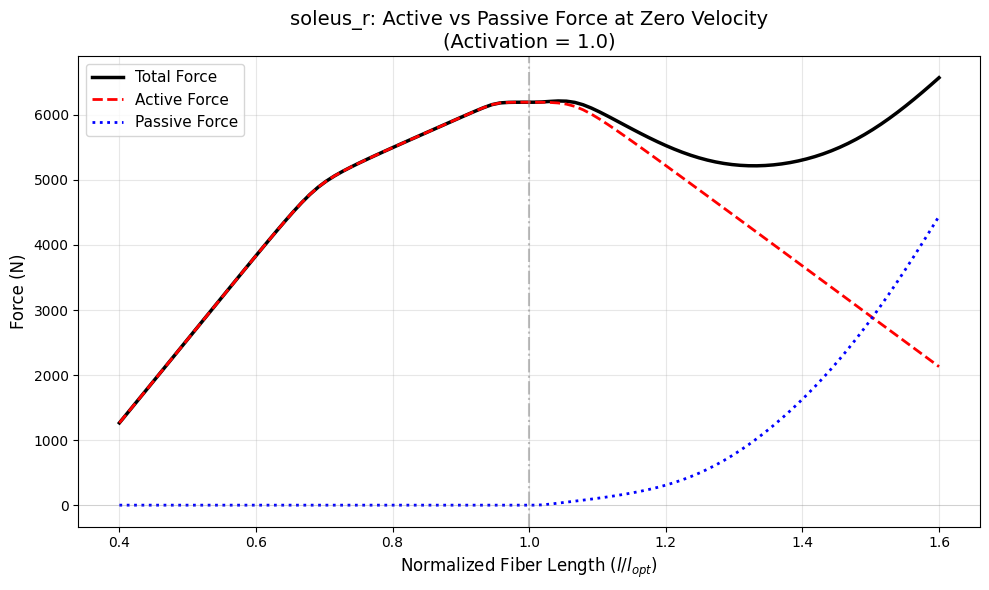


Summary at optimal length (l/l_opt = 1.0):
  Active force: 6194.83 N
  Passive force: 0.00 N
  Total force: 6194.83 N
  Passive force contribution: 0.00%

Creating 3D FLV Surface Plot...


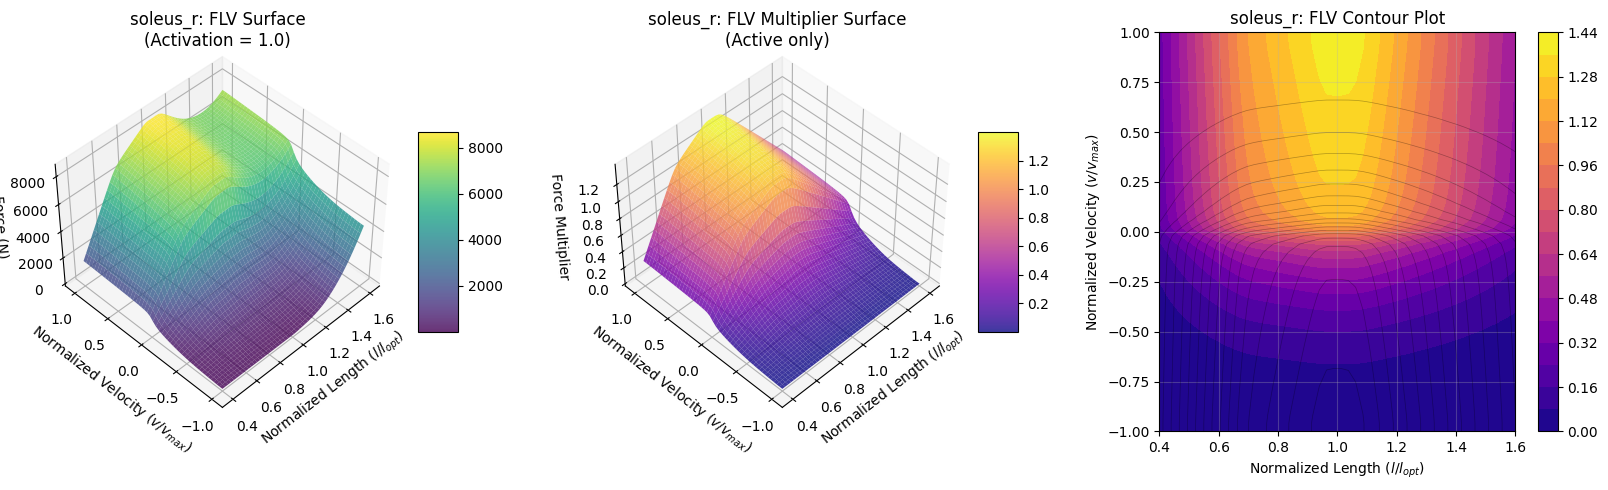

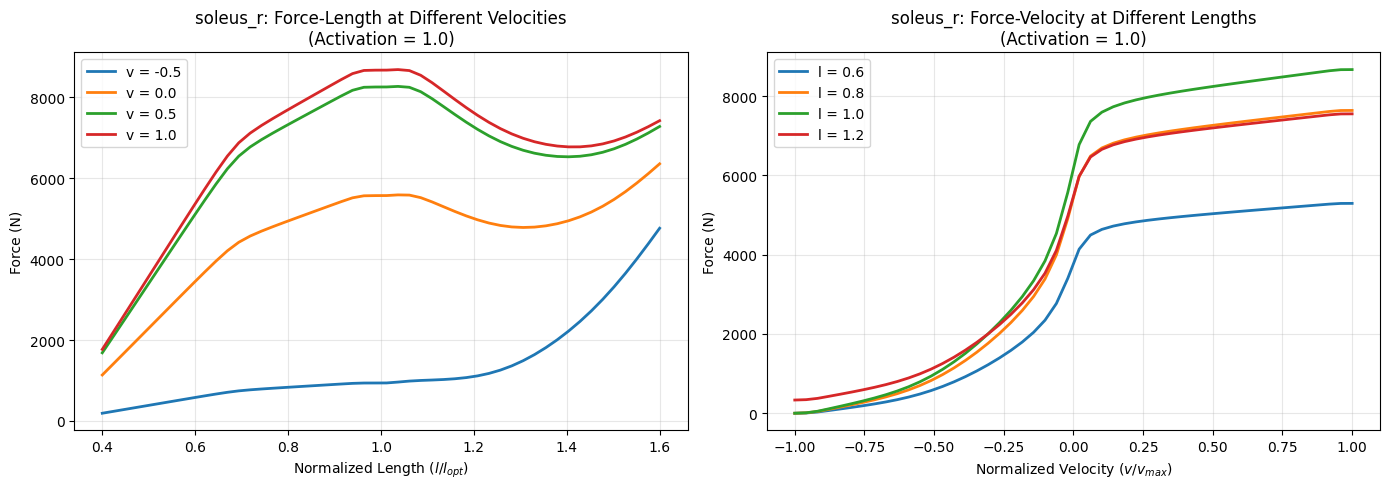


Summary:
  Max isometric force: 6194.84 N
  Max force multiplier: 1.4000
  Min force multiplier: 0.0000


In [61]:
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt

# 1. Load model
model_path = 'opensim_models/Rajagopal/Rajagopal2016.osim'
model = osim.Model(model_path)
model.initSystem()

# 2. Select muscle
muscle_name = 'soleus_r'
base_muscle = model.getMuscles().get(muscle_name)
muscle = osim.Millard2012EquilibriumMuscle.safeDownCast(base_muscle)

if not muscle:
    print(f"Error: Muscle '{muscle_name}' not found.")
    exit()

print(f"Analyzing FLV curve for: {muscle_name}")

# 3. Get curves and properties
active_fl_curve = muscle.getActiveForceLengthCurve()
fiber_fl_curve = muscle.getFiberForceLengthCurve()
fv_curve = muscle.getForceVelocityCurve()
max_isometric_force = muscle.getMaxIsometricForce()
optimal_fiber_length = muscle.getOptimalFiberLength()
pennation_angle = muscle.getPennationAngleAtOptimalFiberLength()

print(f"\nMuscle Properties:")
print(f"  Max isometric force (fiber force): {max_isometric_force:.2f} N")
print(f"  Optimal fiber length: {optimal_fiber_length:.4f} m")
print(f"  Pennation angle at optimal: {pennation_angle:.4f} rad ({np.degrees(pennation_angle):.2f}°)")
print(f"  Tendon force at optimal (max activation, zero velocity): {max_isometric_force * np.cos(pennation_angle):.2f} N")
print(f"\nNote: max_isometric_force is FIBER force, not tendon force.")
print(f"      Actual tendon force = fiber_force × cos(pennation_angle)")

# 4. Calculate forces at zero velocity (isometric)
norm_lengths_2d = np.linspace(0.4, 1.6, 100)
activation_2d = 1.0
v_norm_2d = 0.0  # Zero velocity

active_forces_2d = []
passive_forces_2d = []
total_forces_2d = []

for l_norm in norm_lengths_2d:
    # Active force = activation × active_FL(L) × FV(V) × max_isometric_force
    active_fl_mult = active_fl_curve.calcValue(l_norm)
    fv_mult = fv_curve.calcValue(v_norm_2d)
    active_force = activation_2d * active_fl_mult * fv_mult * max_isometric_force
    
    # Passive force = passive_FL(L) × max_isometric_force (velocity independent)
    passive_fl_mult = fiber_fl_curve.calcValue(l_norm)
    passive_force = passive_fl_mult * max_isometric_force
    
    # Total force = Active + Passive
    total_force = active_force + passive_force
    
    active_forces_2d.append(active_force)
    passive_forces_2d.append(passive_force)
    total_forces_2d.append(total_force)

# 5. Plot 2D graph
plt.figure(figsize=(10, 6))
plt.plot(norm_lengths_2d, total_forces_2d, label='Total Force', color='black', linewidth=2.5, linestyle='-')
plt.plot(norm_lengths_2d, active_forces_2d, label='Active Force', color='red', linewidth=2, linestyle='--')
plt.plot(norm_lengths_2d, passive_forces_2d, label='Passive Force', color='blue', linewidth=2, linestyle=':')
plt.xlabel('Normalized Fiber Length ($l / l_{{opt}}$)', fontsize=12)
plt.ylabel('Force (N)', fontsize=12)
plt.title(f'{muscle_name}: Active vs Passive Force at Zero Velocity\n(Activation = {activation_2d:.1f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='best')
plt.axvline(x=1.0, color='gray', linestyle='-.', alpha=0.5, linewidth=1.5, label='Optimal Length')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"\nSummary at optimal length (l/l_opt = 1.0):")
optimal_idx = np.argmin(np.abs(norm_lengths_2d - 1.0))
print(f"  Active force: {active_forces_2d[optimal_idx]:.2f} N")
print(f"  Passive force: {passive_forces_2d[optimal_idx]:.2f} N")
print(f"  Total force: {total_forces_2d[optimal_idx]:.2f} N")
print(f"  Passive force contribution: {passive_forces_2d[optimal_idx]/total_forces_2d[optimal_idx]*100:.2f}%")

# 6. Create 3D FLV Surface Plot
from mpl_toolkits.mplot3d import Axes3D

print(f"\nCreating 3D FLV Surface Plot...")

# Create meshgrid for normalized length and velocity
norm_lengths_3d = np.linspace(0.4, 1.6, 50)
norm_velocities_3d = np.linspace(-1.0, 1.0, 50)
L, V = np.meshgrid(norm_lengths_3d, norm_velocities_3d)

# Calculate force multipliers for each combination
activation_3d = 1.0

FL_mult = np.zeros_like(L)
FV_mult = np.zeros_like(L)
Total_Force = np.zeros_like(L)

for i in range(len(norm_velocities_3d)):
    for j in range(len(norm_lengths_3d)):
        l = norm_lengths_3d[j]
        v = norm_velocities_3d[i]
        
        # Get multipliers from curves
        active_fl_mult = active_fl_curve.calcValue(l)
        passive_fl_mult = fiber_fl_curve.calcValue(l)
        fv_mult = fv_curve.calcValue(v)
        
        # Calculate forces
        # Active force = activation × active_FL(L) × FV(V) × max_isometric_force
        active_force = activation_3d * active_fl_mult * fv_mult * max_isometric_force
        
        # Passive force = passive_FL(L) × max_isometric_force (velocity independent)
        passive_force = passive_fl_mult * max_isometric_force
        
        # Total force = Active + Passive
        total_force = active_force + passive_force
        
        FL_mult[i, j] = active_fl_mult
        FV_mult[i, j] = fv_mult
        Total_Force[i, j] = total_force

# Visualization - 3D Surface Plot
fig = plt.figure(figsize=(16, 5))

# Plot 1: Force-Length-Velocity Surface (Total Force)
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(L, V, Total_Force, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
ax1.set_xlabel('Normalized Length ($l/l_{{opt}}$)')
ax1.set_ylabel('Normalized Velocity ($v/v_{{max}}$)')
ax1.set_zlabel('Force (N)')
ax1.set_title(f'{muscle_name}: FLV Surface\n(Activation = {activation_3d:.1f})')
ax1.view_init(elev=45, azim=-135)  # Rotate 45 degrees
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Plot 2: Force-Length-Velocity Surface (Force Multiplier)
ax2 = fig.add_subplot(132, projection='3d')
Force_Multiplier = FL_mult * FV_mult  # Combined multiplier (active only)
surf2 = ax2.plot_surface(L, V, Force_Multiplier, cmap='plasma', alpha=0.8, linewidth=0, antialiased=True)
ax2.set_xlabel('Normalized Length ($l/l_{{opt}}$)')
ax2.set_ylabel('Normalized Velocity ($v/v_{{max}}$)')
ax2.set_zlabel('Force Multiplier')
ax2.set_title(f'{muscle_name}: FLV Multiplier Surface\n(Active only)')
ax2.view_init(elev=45, azim=-135)  # Rotate 45 degrees
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

# Plot 3: Contour Plot
ax3 = fig.add_subplot(133)
contour = ax3.contourf(L, V, Force_Multiplier, levels=20, cmap='plasma')
ax3.contour(L, -V, Force_Multiplier, levels=20, colors='black', alpha=0.3, linewidths=0.5)
ax3.set_xlabel('Normalized Length ($l/l_{{opt}}$)')
ax3.set_ylabel('Normalized Velocity ($v/v_{{max}}$)')
ax3.set_title(f'{muscle_name}: FLV Contour Plot')
ax3.grid(True, alpha=0.3)
fig.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# 7. Additional: Cross-sections at different velocities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cross-section 1: Force vs Length at different velocities
velocities_to_plot = [-0.5, 0.0, 0.5, 1.0]
for v in velocities_to_plot:
    v_idx = np.argmin(np.abs(norm_velocities_3d - v))
    forces_at_v = Total_Force[v_idx, :]
    axes[0].plot(norm_lengths_3d, forces_at_v, label=f'v = {v:.1f}', linewidth=2)

axes[0].set_xlabel('Normalized Length ($l/l_{{opt}}$)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title(f'{muscle_name}: Force-Length at Different Velocities\n(Activation = {activation_3d:.1f})')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Cross-section 2: Force vs Velocity at different lengths
lengths_to_plot = [0.6, 0.8, 1.0, 1.2]
for l in lengths_to_plot:
    l_idx = np.argmin(np.abs(norm_lengths_3d - l))
    forces_at_l = Total_Force[:, l_idx]
    axes[1].plot(norm_velocities_3d, forces_at_l, label=f'l = {l:.1f}', linewidth=2)

axes[1].set_xlabel('Normalized Velocity ($v/v_{{max}}$)')
axes[1].set_ylabel('Force (N)')
axes[1].set_title(f'{muscle_name}: Force-Velocity at Different Lengths\n(Activation = {activation_3d:.1f})')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Max isometric force: {max_isometric_force:.2f} N")
print(f"  Max force multiplier: {np.max(Force_Multiplier):.4f}")
print(f"  Min force multiplier: {np.min(Force_Multiplier):.4f}")


# Extract all parameters